## Get data

In [1]:
#imports
from astroquery.gaia import Gaia
import pandas as pd 
import seaborn as sns
import math
import matplotlib.pyplot as plt

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
#gaia query
job = Gaia.launch_job_async("SELECT ALL gaia_source.source_id,gaia_source.ra,gaia_source.dec,gaia_source.pmra,gaia_source.pmdec,gaia_source.phot_bp_mean_mag FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',183.721,12.785,3))=1  AND  (gaiadr2.gaia_source.phot_bp_mean_mag<=17)")

Query finished.


In [16]:
#get resulting gaia datatable
r = job.get_results() #print(r['ra','dec'])
df_gaia = r.to_pandas()

In [17]:
#read apt datatable
filename = "ca2183_apt.csv"
df_apt_ = pd.read_csv(filename) 
df_apt = df_apt_[['CentroidRA', 'CentroidDec','Magnitude', 'MagUncertainty']]

## Plots

Text(0.5,1,'Position match')

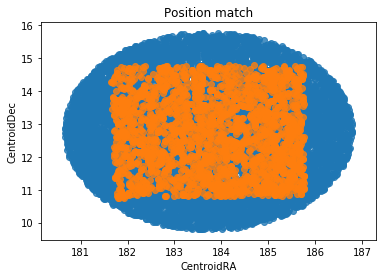

In [68]:
#ra and dec matching
sns.regplot('ra', 'dec', data=df_gaia, fit_reg = False)
sns.regplot('CentroidRA', 'CentroidDec', data=df_apt, fit_reg = False).set_title("Position match")

In [86]:
#set diff
maxdiff = 0.0020 #degree

#matching
df = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag','CentroidRA','CentroidDec','Magnitude','diff'])
m = 0
while m<len(df_gaia):
    #print("m = ",m)
    n = 0
    while n<len(df_apt):
        #print("n = ",n)
        if (df_apt['CentroidRA'][n]-df_gaia['ra'][m])**2+(df_apt['CentroidDec'][n]-df_gaia['dec'][m])**2 < maxdiff**2:
            #print("yes!",n)
            df = df.append({'ra': df_gaia['ra'][m], 'dec': df_gaia['dec'][m], \
                            'phot_bp_mean_mag': df_gaia['phot_bp_mean_mag'][m],\
                            'CentroidRA':df_apt['CentroidRA'][n], 'CentroidDec':df_apt['CentroidDec'][n],\
                            'Magnitude': df_apt['Magnitude'][n], \
                            'diff' : math.sqrt((df_apt['CentroidRA'][n]-df_gaia['ra'][m])**2+\
                                               (df_apt['CentroidDec'][n]-df_gaia['dec'][m])**2),\
                            'Δra': df_gaia['ra'][m] - df_apt['CentroidRA'][n],\
                           'Δdec': df_gaia['dec'][m] - df_apt['CentroidDec'][n]},\
            ignore_index=True)
        n+=1
    m+=1
#drop duplicates
df = df.sort_values('diff').drop_duplicates('ra')
df = df.sort_values('diff').drop_duplicates('CentroidRA')

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


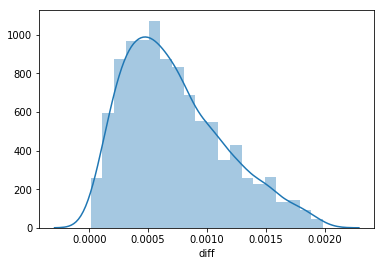

In [93]:
sns.distplot(df['diff'])

In [94]:
#subset
df_filtered = df.query('diff<0.0015')

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Magnitude comparison')

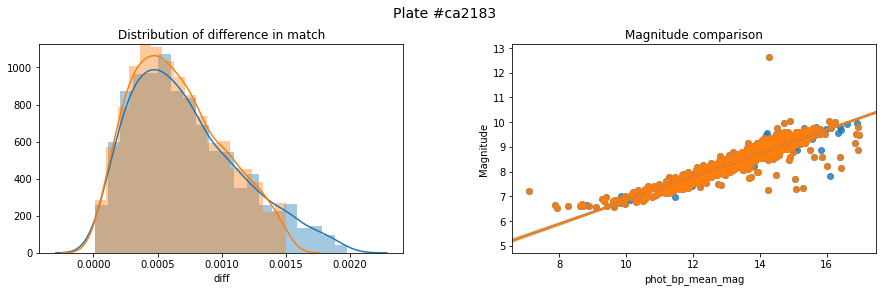

In [95]:
fig = plt.figure(figsize=(15,4))
title = fig.suptitle("Plate #ca2183", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2,1)
sns.distplot(df['diff']).set_title('Distribution of difference in match')
sns.distplot(df_filtered['diff'])

ax2 = fig.add_subplot(1,2,2)
sns.regplot('phot_bp_mean_mag','Magnitude',data=df, fit_reg = True).set_title('Magnitude comparison')
sns.regplot('phot_bp_mean_mag','Magnitude',data=df_filtered).set_title('Magnitude comparison')

Text(0.5,1,'dec vs. Δdec')

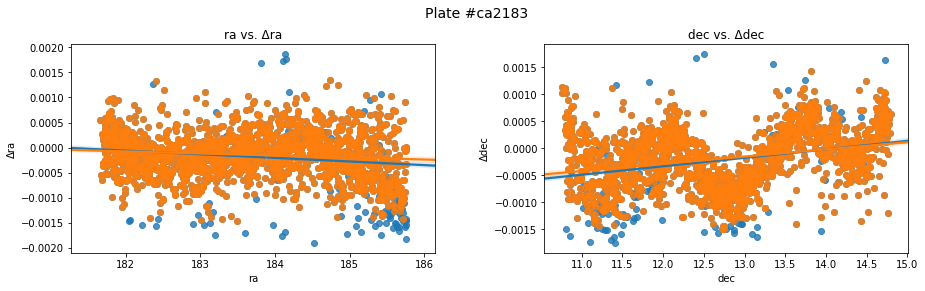

In [96]:
fig = plt.figure(figsize=(15,4))
title = fig.suptitle("Plate #ca2183", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2,1)
sns.regplot('ra','Δra',data=df).set_title('ra vs. Δra')
sns.regplot('ra','Δra',data=df_filtered).set_title('ra vs. Δra')

ax2 = fig.add_subplot(1,2,2)
sns.regplot('dec','Δdec',data=df).set_title('dec vs. Δdec')
sns.regplot('dec','Δdec',data=df_filtered).set_title('dec vs. Δdec')